In [ ]:
!pip install mne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import os 
from PIL import Image
from imageio import imread
import mne

In [ ]:
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam

In [ ]:
fname = '/content/drive/MyDrive/BCI_MI_data/dataset_BCI_IV2a/sub-008.mat'
data = loadmat(fname, struct_as_record = True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x_train', 'y_train', 'x_test', 'y_test', 'channels', 'fmin', 'fmax', 'tmin', 'tmax', 'sf', 'events'])

In [ ]:
channels = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 
            'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']

In [ ]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))

In [ ]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
ten_twenty_montage.remove_fiducials()

<DigMontage | 0 extras (headshape), 0 HPIs, 0 fiducials, 94 channels>

In [ ]:
ten_twenty_montage.plot(kind = 'topomap');

In [ ]:
ch_pos = ten_twenty_montage.get_positions()['ch_pos']
ch_pos

In [ ]:
import collections

ch_pos_22 = collections.OrderedDict((k, ch_pos[k]) for k in channels)

In [ ]:
my_montage = mne.channels.make_dig_montage(ch_pos_22)

In [ ]:
pos_2d = [ch_pos_22[k] for k in ch_pos_22.keys()]
pos = []
for i in range(len(pos_2d)):
  pos.append(pos_2d[i][0])
  pos.append(pos_2d[i][1])
my_pos = np.array(pos).reshape(22,2)

In [ ]:
my_montage.plot(kind = 'topomap');

In [ ]:
X = data['x_train'].transpose([2,1,0])
x_test = data['x_test'].transpose([2,1,0])
y = data['y_train'].squeeze()
y_test = data['y_test'].squeeze()
channels = data['channels']
fs = data['sf'].squeeze()

In [ ]:
print(X.shape)
np.min(X), np.max(X)

(288, 22, 256)


(-7.082395500667123e-05, 6.320784924567974e-05)

In [ ]:
#def NormalizeData(trf):
#  return (trf - np.min(trf)) / (np.max(trf) - np.min(trf))

## Classification with EEGNet, time-series input

In [ ]:
X = X*1000 #scale by 1000 due to scaling sensitivity in deep learning
x_test = x_test*1000
n_ex, C, T = X.shape
X.shape, y.shape

((288, 22, 256), (288,))

In [ ]:
X.min(), X.max()

(-0.07082395500667123, 0.06320784924567974)

#### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
kf = StratifiedKFold(5, shuffle=True, random_state=42) 

 Data and split visualization

In [ ]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [ ]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

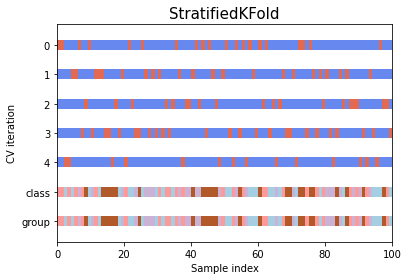

In [ ]:
fig, ax = plt.subplots()
plot_cv_indices(kf, X, y, ax, 5)

In [ ]:
def EEGNet(nb_classes, C, T, 
             dropoutRate = 0.5, kernLength = 32, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (C, T, 1))

    ##################################################################
    block1       = Conv2D(filters=F1, kernel_size=(1, kernLength), padding = 'same',
                                   input_shape = (C, T, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D(kernel_size=(C, 1), use_bias = False, # n_filt == input_depth
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(filters=F2 , kernel_size=(1, 16), 
                                   # filters is the num of 1x1 conv filters,
                                   #  kernel_size is the size of the depthwise conv kernel
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [ ]:
oos_y = []
oos_pred = []

accuracies = []

fold = 0
for train, val in kf.split(X,y):  
    
    print(f"Fold #{fold}")
        
    x_train = X[train]
    y_train = y[train]
    x_val = X[val]
    y_val = y[val]

    x_train = x_train.reshape(x_train.shape[0], C, T, 1)
    x_val = x_val.reshape(x_val.shape[0], C, T, 1)

    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)
    
    model = EEGNet(nb_classes = 4, C = C, T = T, 
              dropoutRate = 0.25, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
              dropoutType = 'Dropout')
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

    #callback = EarlyStopping(monitor = 'val_accuracy', patience = 0)

    fittedModel = model.fit(x_train, y_train, batch_size = 32, epochs = 200,
                            validation_data=(x_val, y_val))#, callbacks=[callback])
    
    probs = model.predict(x_val)
    pred = probs.argmax(axis = -1)  
    
    oos_y.append(y_val)
    # raw probabilities to chosen class (highest probability) 
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_val,axis=-1) # For accuracy calculation
    score = accuracy_score(y_compare, pred)

    accuracies.append(max(fittedModel.history['val_accuracy']))
    fold = fold + 1
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=-1) # For accuracy calculation

score = accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
#oos_y = pd.DataFrame(oos_y)
#oos_pred = pd.DataFrame(oos_pred)
#oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
#oosDF.to_csv(filename_write,index=False)

In [ ]:
accuracies = np.array(accuracies)

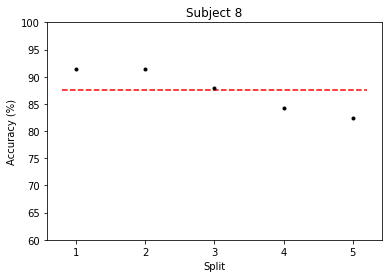

In [ ]:
plt.plot(np.linspace(1,5,5),accuracies*100, 'k.')
plt.hlines(np.mean(accuracies)*100, xmin = 0.8, xmax = 5.2, colors = 'r', linestyles='dashed')
plt.ylim(60, 100)
plt.ylabel('Accuracy (%)')
plt.xlabel('Split')
plt.title('Subject 8');# + conf_sub);

In [ ]:
plt.boxplot(accuracies);

Prediction on test set one of the CV models (not advisable to do that, just to prove that the accuracy of a final model trained on the overall training set cannot be worse than the ones of the CV models)

Training the final model on the overall training set

In [ ]:
model = EEGNet(nb_classes = 4, C = C, T = T, 
               dropoutRate = 0.25, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
    
model.compile(loss='categorical_crossentropy', optimizer='adam', 
          metrics = ['accuracy'])

#callback = EarlyStopping(monitor = 'val_accuracy', patience = 0)

X = X.reshape(X.shape[0], C, T, 1)
y = np_utils.to_categorical(y)

fittedModel = model.fit(X, y, batch_size = 32, epochs = 200, verbose = 0)

In [ ]:
probs       = model.predict(x_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == y_test)
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.767361 


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

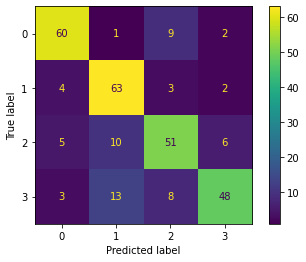

In [ ]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Model interpretation

In [ ]:
tempfilt = model.layers[1].get_weights()[0].squeeze()
tempfilt.shape

(32, 8)

In [ ]:
tempfilt[:,1]

array([ 0.09244471,  0.05779561, -0.2506957 , -0.260163  , -0.2376092 ,
       -0.2623957 ,  0.04929158,  0.10327687,  0.03225772,  0.1461068 ,
       -0.03451157, -0.05275776,  0.11489959, -0.05466094, -0.2508236 ,
       -0.2674357 , -0.14419809,  0.04156433,  0.06404519,  0.22432226,
        0.21828328,  0.09714213,  0.11435056, -0.00048417,  0.00595615,
       -0.10296985, -0.02350715, -0.01355714,  0.07806576,  0.1429404 ,
        0.22243945,  0.08579084], dtype=float32)

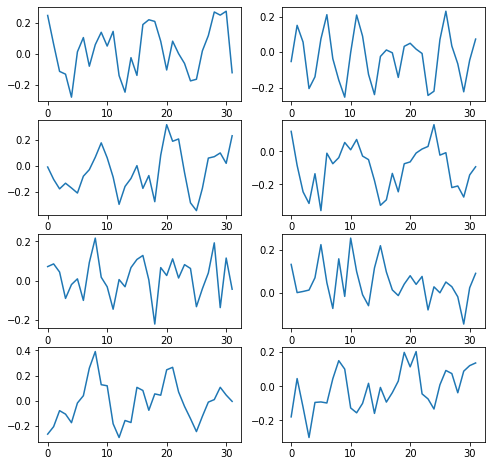

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(tempfilt.shape[1]):
  ax = plt.subplot(4, 2, i+1)
  plt.plot(tempfilt[:,i])

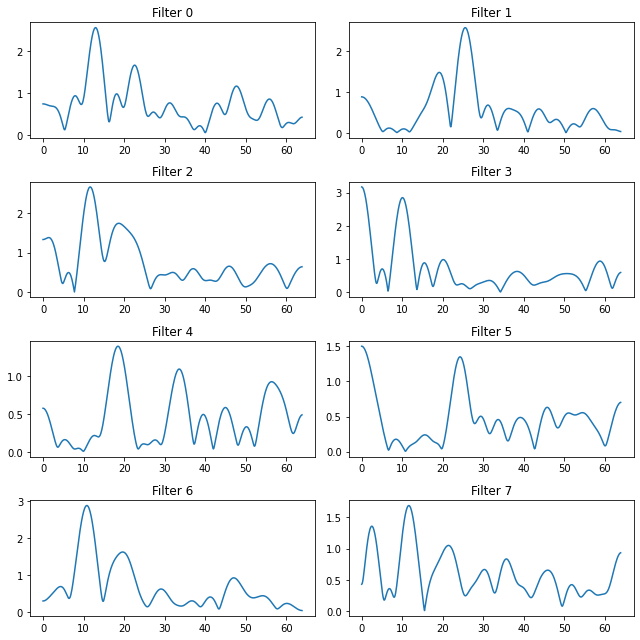

In [ ]:
from scipy import signal
plt.figure(figsize=(9,9))
f_max = []
for i in range(tempfilt.shape[1]):
  ax = plt.subplot(4, 2, i+1)
  f, H = signal.freqz(tempfilt[:,i], fs = 128)
  ax.plot(f, np.abs(H))
  ax.title.set_text('Filter {}' .format(i))
  ix_max = np.argmax(np.abs(H))
  f_max.append(f[ix_max])

plt.tight_layout()
plt.show()

In [ ]:
spat_filt = np.abs(spatfilt)
spat_filt[:,0]
for i in range(spat_filt.shape[1]):
   m = np.max(spat_filt[i,:]);
   spat_filt[i,:] = spat_filt[i,:]/m;


In [ ]:
spatfilt_norm = np.zeros(spatfilt.shape)
for i in range(spatfilt.shape[1]):
    min = np.min(spatfilt[i,:])
    max = np.max(spatfilt[i,:])
    spatfilt_norm[i,:] = 2*((spatfilt[i,:]-min)/(max-min))-1

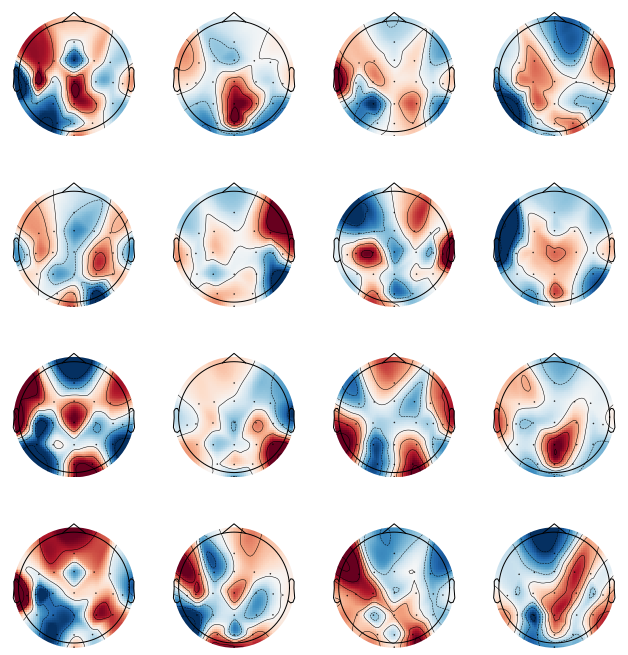

In [ ]:
plt.figure(figsize=(11, 11))
for i in range(spatfilt.shape[1]):
  ax= plt.subplot(4, 4, i+1)
  im, cm = mne.viz.plot_topomap(spatfilt[:,i], my_pos, axes = ax, image_interp = 'none', names = channels, show = False, show_names = False)
  #clb = fig.colorbar(im)